In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
import datetime as dt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Global settings to increase the font size of plots
plt.rcParams.update({
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 12,
    'font.size': 14
})

# RFM Analysis

# Load Data

In [3]:
# Specify the path to the cutomer_data folder in the parent directory
working_directory = "B:/Projects/Marketing Analytics Project/Marketing-Analysis-unimib/"
data_folder_path = "../Data/"

In [4]:
# Read the cutomer_cutomer_cutomer_data file using pandas
customer_accounts_data = pd.read_csv(data_folder_path + "tbl_customer_accounts.csv")
adresses_data = pd.read_csv(data_folder_path + "tbl_addresses.csv")
customer_data = pd.read_csv(data_folder_path + "tbl_customers.csv")
orders_data = pd.read_csv(data_folder_path + "tbl_orders.csv")
products_data = pd.read_csv(data_folder_path + "tbl_products.csv")
customer_reviews_data = pd.read_csv(data_folder_path + "tbl_customer_reviews.csv")
labelled_reviews_data = pd.read_csv(data_folder_path + "tbl_labelled_reviews.csv")

In [5]:
# Ensure purchase_datetime is in datetime format
orders_data['purchase_datetime'] = pd.to_datetime(orders_data['purchase_datetime'])

In [6]:
# Remove suspicious data with negative prices in purchases
orders_data = orders_data[~((orders_data['direction'] == 1 ) & (orders_data['gross_price'] < 0))]

# Extract Recency, Frequency and Monetary Value

In [7]:
# Set reference date for recency calculation
reference_date = orders_data['purchase_datetime'].max() + dt.timedelta(days=1)

# Calculate RFM metrics
rfm_table = orders_data.groupby('customer_id').agg({
    'purchase_datetime': lambda x: (reference_date - x.max()).days,  # Recency
    'order_id': 'nunique',                                             # Frequency
    'gross_price': 'sum'                                             # Monetary Value
}).reset_index()

# Rename columns
rfm_table.rename(columns={
    'purchase_datetime': 'Recency',
    'order_id': 'Frequency',
    'gross_price': 'Monetary Value'
}, inplace=True)


In [8]:
rfm_table

,customer_id,Recency,Frequency,Monetary Value
0,23,70,8,483.51
1,30,282,2,10179.56
2,32,29,3,58.85
3,48,1,20,1053.62
4,50,71,2,28.75
...,...,...,...,...
104129,934484,1,1,39.10
104130,934581,1,1,33.60
104131,934620,1,1,21.98
104132,934660,1,1,1.90


# Cleaning the Data

## INACTIVE/ACTIVE CUSTOMERS

In [9]:
# Assuming orders_data is already defined
dates = orders_data.copy()

# Ensure 'purchase_datetime' is in datetime format
dates['purchase_datetime'] = pd.to_datetime(dates['purchase_datetime']).dt.date

# Drop duplicate transaction IDs to ensure each transaction is only counted once
unique_transactions = dates.drop_duplicates(subset=['order_id'])

# Sort by customer_id and purchase_datetime
buyback_clients = unique_transactions.sort_values(['customer_id', 'purchase_datetime'])

# Calculate the time difference between subsequent purchases
buyback_clients['time_diff'] = buyback_clients.groupby('customer_id')['purchase_datetime'].diff()

# Drop rows with NaN values in 'time_diff' (first purchase of each customer)
buyback_clients = buyback_clients.dropna()

# Convert 'time_diff' to timedelta to access days
buyback_clients['time_diff'] = pd.to_timedelta(buyback_clients['time_diff'])

# Filter out rows with a time difference of 0 days
buyback_clients = buyback_clients[buyback_clients['time_diff'].dt.days > 0]

# Calculate the average time in days
average_time_days = buyback_clients['time_diff'].dt.days.mean()

print(f"The average time for any customer to return and make a purchase is {average_time_days:.2f} days.")


The average time for any customer to return and make a purchase is 34.22 days.


### Churners
In the context of repurchase time scale, finding the outliers would also mean finding churners. Values which are derivative to the data context. using Inter Quantile Method we can find these values and find an upper bound to set out churners.

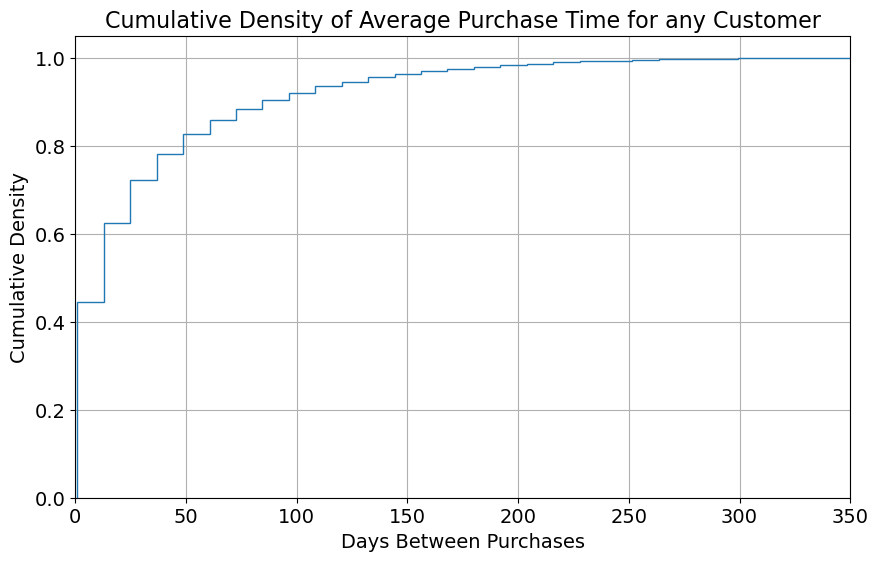

In [10]:
# Plot the cumulative histogram as a density curve
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(buyback_clients['time_diff'].dt.days, bins=30, density=True, cumulative=True, histtype='step', alpha=1)
plt.title('Cumulative Density of Average Purchase Time for any Customer')
plt.xlabel('Days Between Purchases')
plt.ylabel('Cumulative Density')
plt.grid(True)
plt.xlim([0,350])
plt.show()

In [11]:
buyback_clients['days_diff'] = buyback_clients['time_diff'].dt.days

In [12]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = buyback_clients['days_diff'].quantile(0.25)
Q3 = buyback_clients['days_diff'].quantile(0.75)

# Compute the IQR
IQR = Q3 - Q1

# Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers on the right side of the distribution
right_side_outliers = buyback_clients[buyback_clients['days_diff'] > upper_bound]

right_side_outliers.sort_values('days_diff', ascending=False)

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,time_diff,days_diff
197180,ba04cb184f75fa0dec63ed6c87b77259,159943,38,35315231,1,3.25,0.0,2023-04-25,359 days,359
263654,d4480d2475719321cddef37841484d1b,226000,35,36141532,1,29.70,0.0,2023-04-25,359 days,359
242985,a9f64d1931e8aef6ec601a25cfa570df,206146,25,35736680,1,0.24,0.0,2023-04-25,358 days,358
408646,a1fae659e5fe94214b8071c1d8baf0eb,352081,20,35609266,1,2.00,0.0,2023-04-26,357 days,357
108870,b50067191cf961c299f68547985347cf,77132,43,34060873,1,4.99,0.0,2023-04-30,357 days,357
...,...,...,...,...,...,...,...,...,...,...
595267,5af7fb828e4ebf9827a9e2edde2dd461,471937,14,35737093,1,0.07,0.0,2022-10-28,97 days,97
293700,c2cce8af2e8aab41947e9ad15ff7e107,254632,11,81264045,1,13.98,2.8,2023-01-27,97 days,97
143688,cb14c11952fec9fa1078daf984ff9054,103326,19,34985104,1,99.50,40.0,2023-01-02,97 days,97
292948,94f1c8a8e163602496c2b62d87f6525e,254063,33,32497920,1,2.60,0.0,2023-01-25,97 days,97


In [13]:
churn_threshold = int(upper_bound)
print(f"The upper bound for outliers and churning threshold is {churn_threshold} days.")

The upper bound for outliers and churning threshold is 96 days.


### Label Inactive/Active in rfm

In [14]:
rfm_table['Active'] = rfm_table['Recency'].apply(lambda x: 1 if x <= churn_threshold else 0)

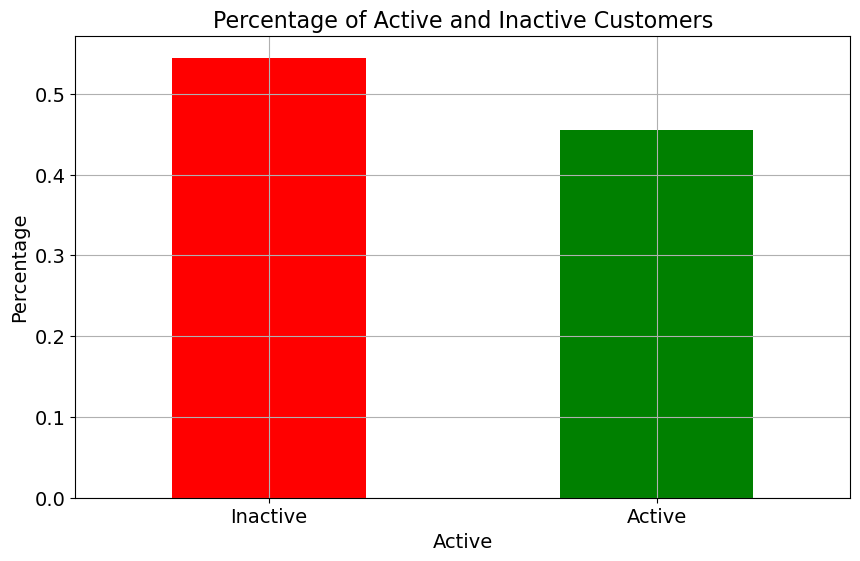

In [37]:
# bar chart of active and inactive customers y in percentage
fig, ax = plt.subplots(figsize=(10, 6))
rfm_table['Active'].value_counts(normalize=True).plot(kind='bar', color=['red', 'green'], ax=ax)
plt.title('Percentage of Active and Inactive Customers')
plt.xlabel('Active')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Inactive', 'Active'], rotation=0)
plt.grid(True)
plt.show()

## Negative Accounts

There are customers with a negative value for customer monetary value. Those are set aside and labeled as Anomaly Customers.

In [38]:
# in rfm table label the customers with negative monetary value as Anomaly Customer
rfm_table['Anomaly'] = rfm_table['Monetary Value'].apply(lambda x: 1 if x < 0 else 0)

In [40]:
rfm_table['Anomaly'].value_counts()

Anomaly
0    104056
1        78
Name: count, dtype: int64

In [142]:
active_customers_rfm = rfm_table[(rfm_table['Active'] == 1) & (rfm_table['Anomaly'] == 0)]

## Distribution

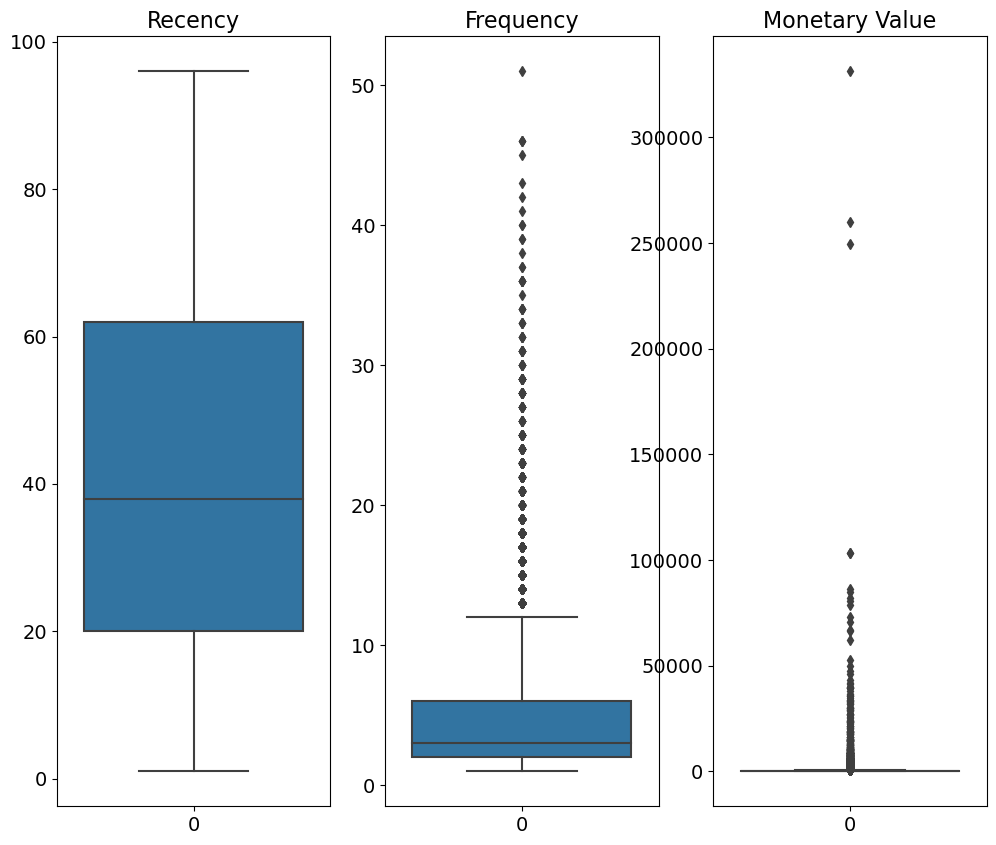

In [143]:
# show me box plot of recency, frequency and monetary value
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(1, 3, 1); sns.boxplot(active_customers_rfm['Recency'])
plt.title('Recency')
# Plot distribution of F
plt.subplot(1, 3, 2); sns.boxplot(active_customers_rfm['Frequency'])
plt.title('Frequency')
# Plot distribution of M
plt.subplot(1, 3, 3); sns.boxplot(active_customers_rfm['Monetary Value'])
plt.title('Monetary Value')
plt.show()

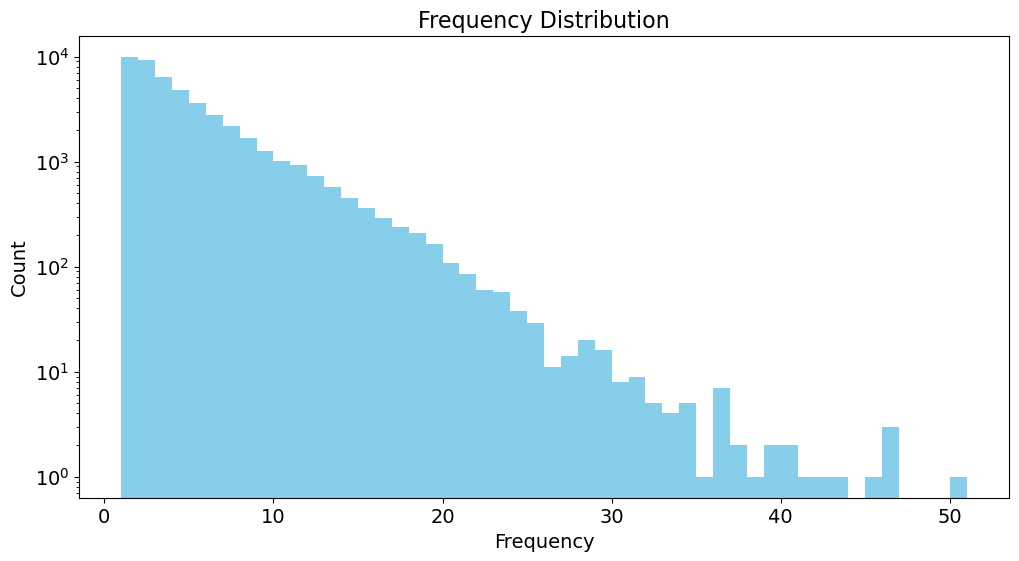

In [144]:
# frequency distribution
plt.figure(figsize=(12,6))
plt.hist(active_customers_rfm['Frequency'], bins=50, color='skyblue', log=True)
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.title('Frequency Distribution')
plt.show()

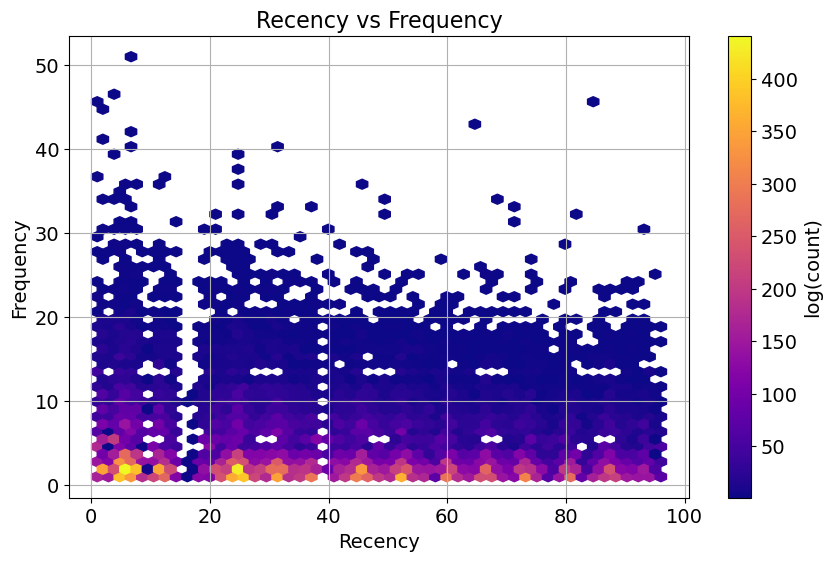

In [145]:
plt.figure(figsize=(10,6))
hb = plt.hexbin(active_customers_rfm['Recency'], active_customers_rfm['Frequency'], gridsize=50, cmap='plasma', mincnt=1, reduce_C_function=np.log1p)
cb = plt.colorbar(hb)
cb.set_label('log(count)')
plt.title('Recency vs Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Monetary Value

In [146]:
active_customers_rfm['Monetary Value Log'] = np.log1p(active_customers_rfm['Monetary Value']) 

C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\3389989094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['Monetary Value Log'] = np.log1p(active_customers_rfm['Monetary Value'])


In [147]:
# Calculate the interquartile range (IQR)
Q1 = active_customers_rfm['Monetary Value Log'].quantile(0.25)
Q3 = active_customers_rfm['Monetary Value Log'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper bound for outliers
upper_bound = Q3 + 1.5 * IQR
upper_bound

lower_bound = 0

selected_monetary_values = active_customers_rfm[(active_customers_rfm['Monetary Value Log'] > lower_bound) & (active_customers_rfm['Monetary Value Log'] < upper_bound)]

In [148]:
selected_monetary_values.describe().apply(lambda x: x.round().astype(int))

,customer_id,Recency,Frequency,Monetary Value,Active,Anomaly,Monetary Value Log
count,47050,47050,47050,47050,47050,47050,47050
mean,500071,41,5,227,1,0,4
std,285250,27,4,470,0,0,2
min,23,1,1,0,1,0,0
25%,239868,20,2,24,1,0,3
50%,540552,38,3,75,1,0,4
75%,767674,62,6,221,1,0,5
max,934716,96,51,6307,1,0,9


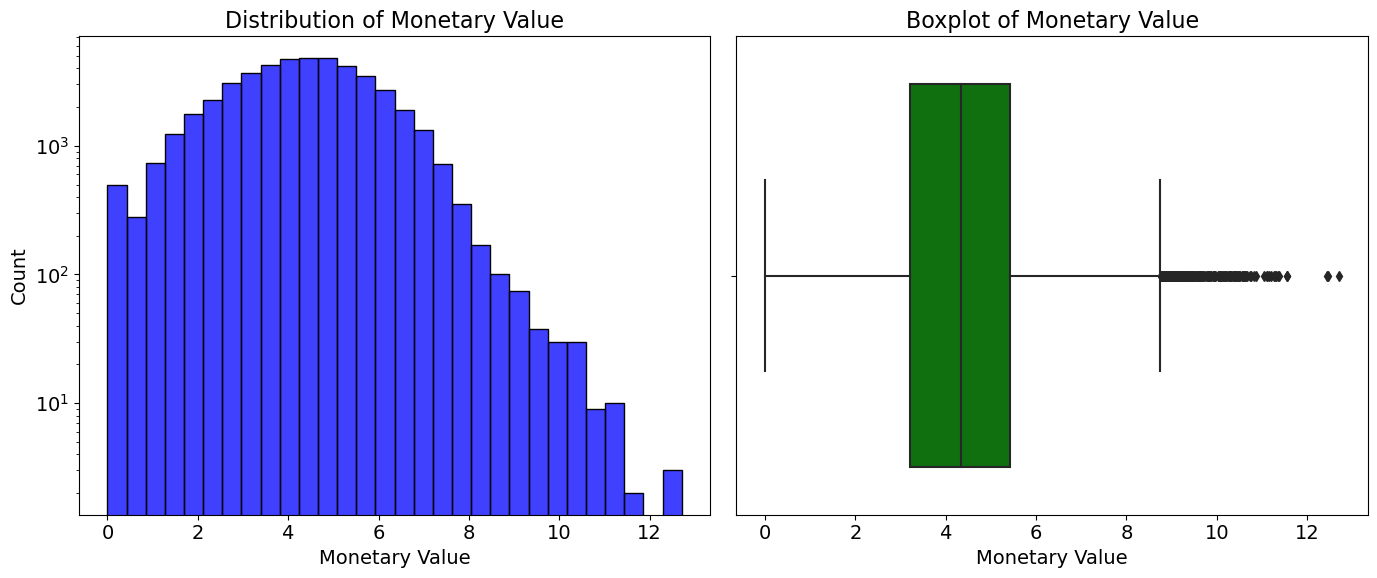

In [149]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot the histogram of Monetary Value with log scale
plt.subplot(1, 2, 1)
sns.histplot(active_customers_rfm['Monetary Value Log'], bins=30, color='blue')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Count')
plt.yscale('log')

# Plot the boxplot of Monetary Value with log scale
plt.subplot(1, 2, 2)
sns.boxplot(x=active_customers_rfm['Monetary Value Log'], color='green')
plt.title('Boxplot of Monetary Value')
plt.xlabel('Monetary Value')

# Adjust layout
plt.tight_layout()
plt.show()

In [150]:
outliers = active_customers_rfm[active_customers_rfm['Monetary Value Log'] > upper_bound]

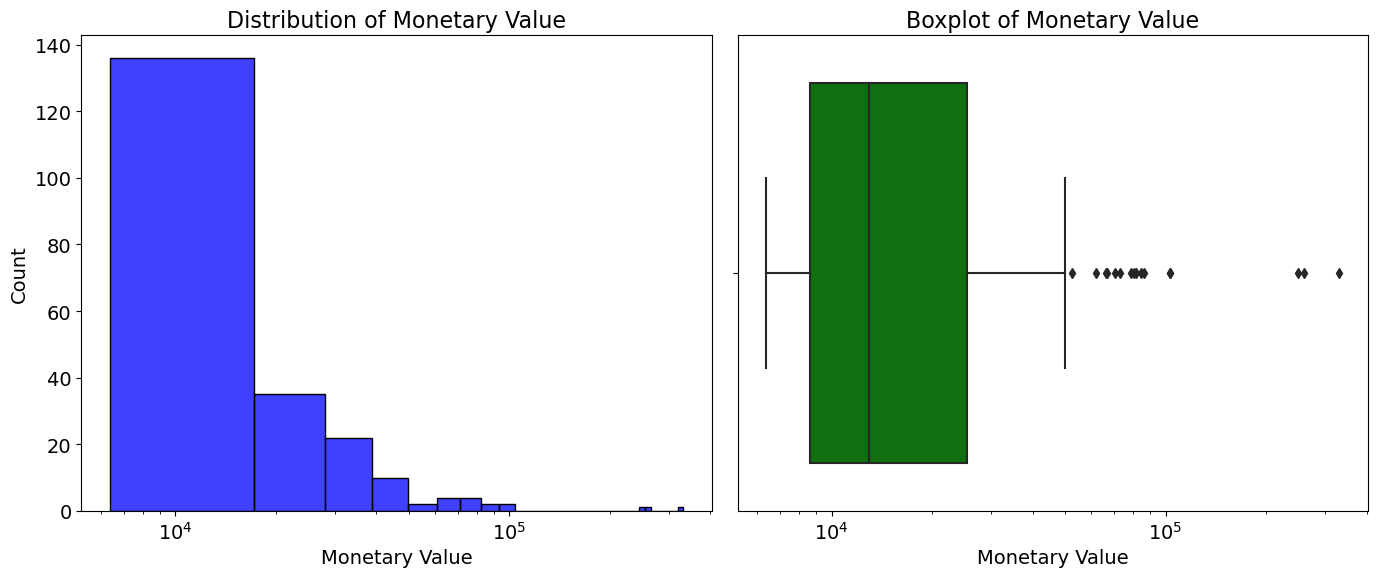

In [151]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot the histogram of Monetary Value with log scale
plt.subplot(1, 2, 1)
sns.histplot(outliers['Monetary Value'], bins=30, color='blue')
plt.title('Distribution of Monetary Value')
plt.xlabel('Monetary Value')
plt.ylabel('Count')
plt.xscale('log')

# Plot the boxplot of Monetary Value with log scale
plt.subplot(1, 2, 2)
sns.boxplot(x=outliers['Monetary Value'], color='green')
plt.title('Boxplot of Monetary Value')
plt.xlabel('Monetary Value')
plt.xscale('log')

# Adjust layout
plt.tight_layout()
plt.show()

# Clustering

By clustering customers with similar RFM scores, businesses can gain valuable insights into their customer base and tailor their marketing and retention strategies accordingly.

1. First clusters are extracted from Recency/Frequency values to find below types.
    - **Frequent Active Customers**: Customers who purchase frequently and have done so recently.
    - **Frequent Reduced Activity**: Customers who purchase frequently but have shown a recent decline in activity.
    - **Frequent At-Risk**: Customers who used to purchase frequently but haven't made a purchase recently.
    - **Occasional Active Customers**: Customers who purchase occasionally but have done so recently.
    - **Occasional Reduced Activity**: Customers who purchase occasionally and have shown a recent decline in activity.
    - **Occasional At-Risk**: Customers who used to purchase occasionally but haven't made a purchase recently.
    - **Potential Occasional**: Customers with an F_Score of 2 and R_Score of 1 or 2, indicating potential for occasional purchases.
    - **Burnt Potential**: Customers with an F_Score of 2 and R_Score of 3 or 4, indicating they might be lost potential.
    - **One-Timers**: Customers with little to no Frequency.


In [152]:
active_customers_rfm

,customer_id,Recency,Frequency,Monetary Value,Active,Anomaly,Monetary Value Log
0,23,70,8,483.51,1,0,6.183138
2,32,29,3,58.85,1,0,4.091841
3,48,1,20,1053.62,1,0,6.960936
4,50,71,2,28.75,1,0,3.392829
6,76,54,2,14.60,1,0,2.747271
...,...,...,...,...,...,...,...
104129,934484,1,1,39.10,1,0,3.691376
104130,934581,1,1,33.60,1,0,3.543854
104131,934620,1,1,21.98,1,0,3.134624
104132,934660,1,1,1.90,1,0,1.064711


## Recency and Frequency

In [153]:
# Define thresholds for scoring
freq_threshold_1 = active_customers_rfm['Frequency'].quantile(0.2)
freq_threshold_2 = active_customers_rfm['Frequency'].quantile(0.5)
freq_threshold_3 = active_customers_rfm['Frequency'].quantile(0.8)

rec_threshold_1 = active_customers_rfm['Recency'].quantile(0.2)
rec_threshold_2 = active_customers_rfm['Recency'].quantile(0.5)
rec_threshold_3 = active_customers_rfm['Recency'].quantile(0.8)

# Scoring function for Recency
def recency_score(x):
    if x <= rec_threshold_1:
        return 1
    elif x <= rec_threshold_2:
        return 2
    elif x <= rec_threshold_3:
        return 3
    else:
        return 4

# Scoring function for Frequency
def frequency_score(x):
    if x <= freq_threshold_1:
        return 1
    elif x <= freq_threshold_2:
        return 2
    elif x <= freq_threshold_3:
        return 3
    else:
        return 4

# Apply the scoring functions
active_customers_rfm['R_Score'] = active_customers_rfm['Recency'].apply(recency_score)
active_customers_rfm['F_Score'] = active_customers_rfm['Frequency'].apply(frequency_score)


C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\3583172392.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['R_Score'] = active_customers_rfm['Recency'].apply(recency_score)
C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\3583172392.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['F_Score'] = active_customers_rfm['Frequency'].apply(frequency_score)


In [154]:
freq_threshold_1 ,freq_threshold_2 ,freq_threshold_3

(1.0, 3.0, 7.0)

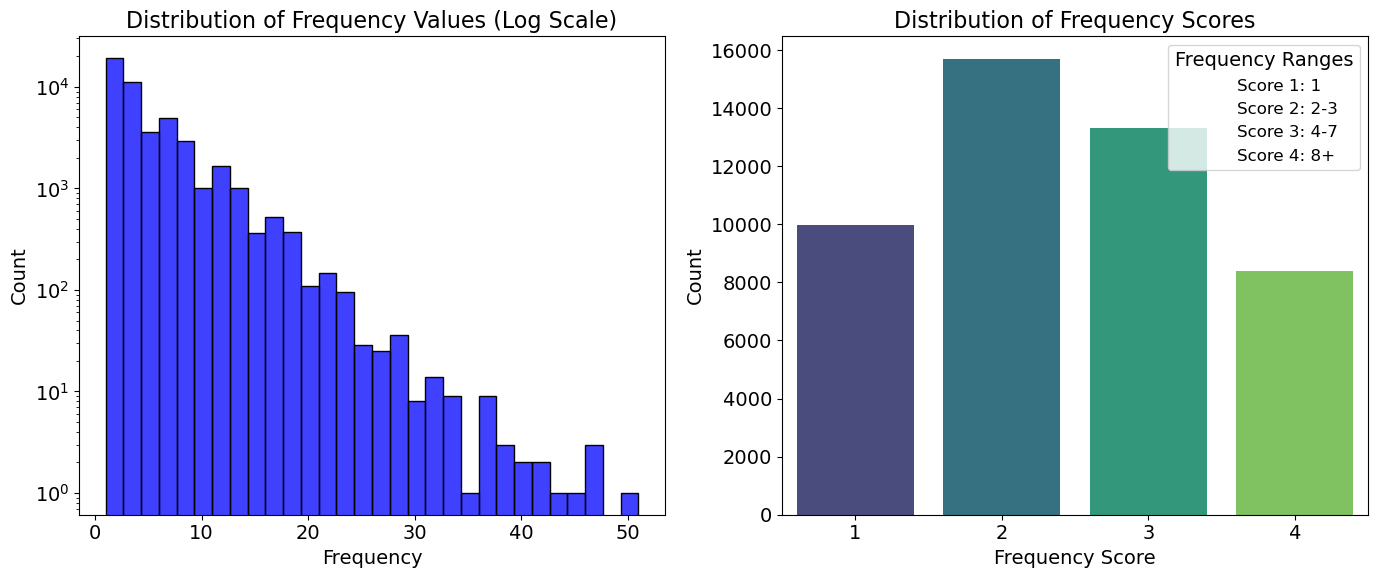

In [155]:
import matplotlib.patches as mpatches

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot the distribution of Frequency values
plt.subplot(1, 2, 1)
sns.histplot(active_customers_rfm['Frequency'], bins=30, color='blue')
plt.title('Distribution of Frequency Values (Log Scale)')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Plot the distribution of Frequency scores
plt.subplot(1, 2, 2)
sns.countplot(x='F_Score', data=active_customers_rfm, palette='viridis')
plt.title('Distribution of Frequency Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Count')

# Add frequency range annotations
frequency_ranges = {
    1: '1',
    2: '2-3',
    3: '4-7',
    4: '8+',
}

legend_handles = [mpatches.Patch(color='none', label=f'Score {score}: {range_text}') for score, range_text in frequency_ranges.items()]
plt.legend(handles=legend_handles, title='Frequency Ranges', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

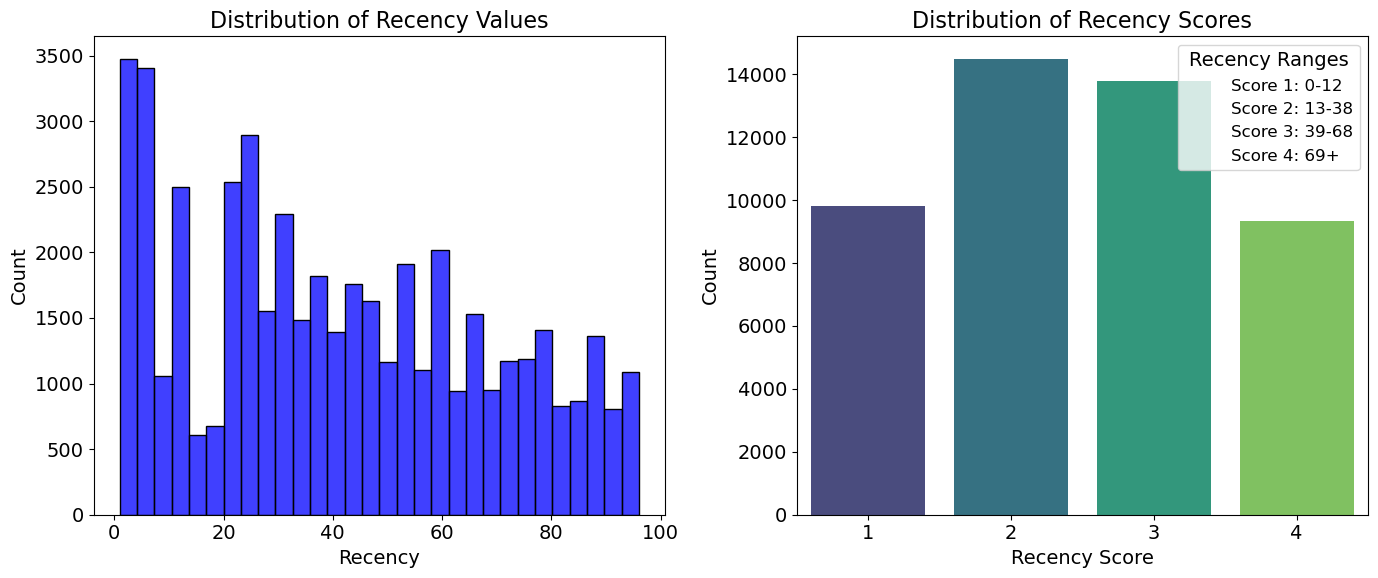

In [156]:

# Define the recency ranges for the legend
recency_ranges = {
    1: f'0-{rec_threshold_1:.0f}',
    2: f'{rec_threshold_1+1:.0f}-{rec_threshold_2:.0f}',
    3: f'{rec_threshold_2+1:.0f}-{rec_threshold_3:.0f}',
    4: f'{rec_threshold_3+1:.0f}+',
}

# Set up the matplotlib figure
plt.figure(figsize=(14, 6))

# Plot the distribution of Recency values
plt.subplot(1, 2, 1)
sns.histplot(active_customers_rfm['Recency'], bins=30, color='blue')
plt.title('Distribution of Recency Values')
plt.xlabel('Recency')
plt.ylabel('Count')

# Plot the distribution of Recency scores
plt.subplot(1, 2, 2)
sns.countplot(x='R_Score', data=active_customers_rfm, palette='viridis')
plt.title('Distribution of Recency Scores')
plt.xlabel('Recency Score')
plt.ylabel('Count')

# Add recency range annotations
legend_handles = [mpatches.Patch(color='none', label=f'Score {score}: {range_text}') for score, range_text in recency_ranges.items()]
plt.legend(handles=legend_handles, title='Recency Ranges', loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

In [157]:
# Define new label for Potential Occasional and Burnt Potential customers
def label_customer(row):
    if row['F_Score'] == 4:
        if row['R_Score'] == 1:
            return 'Frequent Active Customers'
        elif row['R_Score'] == 2:
            return 'Frequent Reduced Activity'
        else:
            return 'Frequent At-Risk'
    elif row['F_Score'] == 3:
        if row['R_Score'] == 1:
            return 'Occasional Active Customers'
        elif row['R_Score'] == 2 or row['R_Score'] == 3:
            return 'Occasional Reduced Activity'
        else:
            return 'Occasional At-Risk'
    elif row['F_Score'] == 2:
        if row['R_Score'] == 1:
            return 'Potential Occasional'
        elif row['R_Score'] == 2:
            return 'Potential Occasional'
        else:
            return 'Burnt Potential'
    else:
        return 'One-Timers'

# Apply the labeling function
active_customers_rfm['Customer_Label'] = active_customers_rfm.apply(label_customer, axis=1)

C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\866064638.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['Customer_Label'] = active_customers_rfm.apply(label_customer, axis=1)


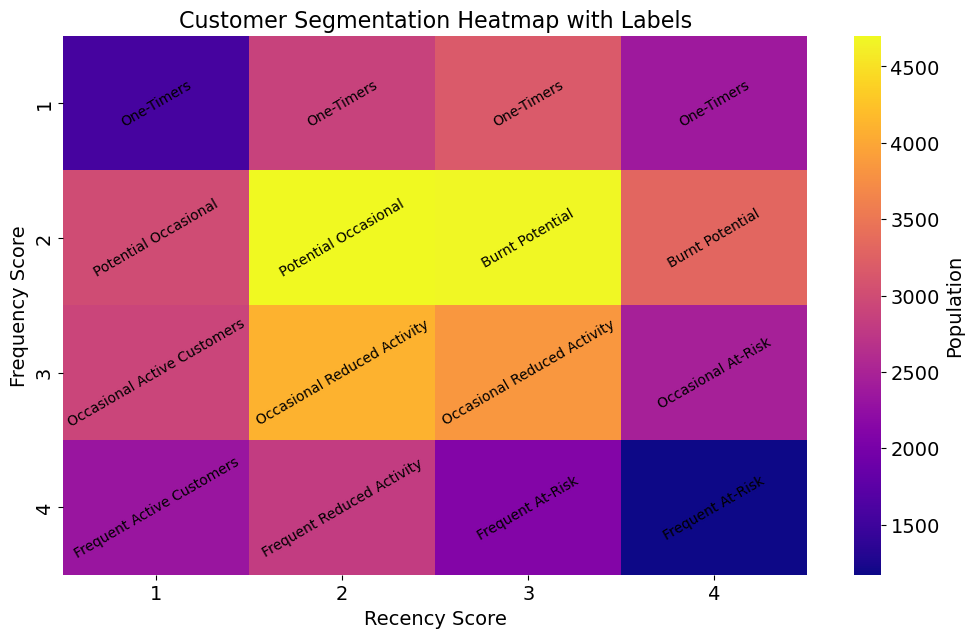

In [158]:
from collections import Counter

# Creating a pivot table for heatmap
heatmap_data = active_customers_rfm.pivot_table(index='F_Score', columns='R_Score', aggfunc='size', fill_value=0)

# Creating a pivot table with the most common label in each cell
label_data = active_customers_rfm.pivot_table(index='F_Score', columns='R_Score', values='Customer_Label', aggfunc=lambda x: Counter(x).most_common(1)[0][0])


# Create the heatmap with numeric values first
plt.figure(figsize=(12, 7))
heatmap = sns.heatmap(heatmap_data, annot=False, fmt='d', cmap='plasma', cbar=True, cbar_kws={'label': 'Population'})

# Annotate the heatmap with customer labels
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        label = label_data.iloc[i, j]
        heatmap.text(j + 0.5, i + 0.5, label, ha='center', va='center', color='black', fontsize=10, rotation=30)

plt.title('Customer Segmentation Heatmap with Labels')
plt.xlabel('Recency Score')
plt.ylabel('Frequency Score')
plt.show()

## Monetary Value Scores and Groups
5 groups are suitable for this values.
1. score 1 : Very low and insignificant
2. score 2 and 3 : values that are distributed normally
3. score 4 and 5 : Extreme values with very high monetary values that are considered outliers.

In [180]:
# Calculate the log of the monetary values
active_customers_rfm['Monetary Value Log'] = np.log1p(active_customers_rfm['Monetary Value'])

# Determine the minimum and maximum of the log-transformed values
min_log_value = active_customers_rfm['Monetary Value Log'].min()
max_log_value = active_customers_rfm['Monetary Value Log'].max()

# Create 4 equal ranges between the minimum and maximum values
ranges = np.linspace(min_log_value, max_log_value, 6)

# Define a function to assign monetary scores based on the log value ranges
def assign_monetary_score(value):
    if value <= ranges[1]:
        return 1
    elif value <= ranges[2]:
        return 2
    elif value <= ranges[3]:
        return 3
    elif value <= ranges[4]:
        return 4
    else:
        return 5

# Apply the function to the dataframe
active_customers_rfm['Monetary Score'] = active_customers_rfm['Monetary Value Log'].apply(assign_monetary_score)

# If you want to see the distribution of scores
print(active_customers_rfm['Monetary Score'].value_counts())

Monetary Score
2    25366
3    14394
1     6813
4      767
5       54
Name: count, dtype: int64


C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\3168784201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['Monetary Value Log'] = np.log1p(active_customers_rfm['Monetary Value'])
C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\3168784201.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['Monetary Score'] = active_customers_rfm['Monetary Value Log'].apply(assign_monetary_score)


In [181]:
# show the minimum and max values of each monetary score
active_customers_rfm.groupby('Monetary Score')['Monetary Value'].agg(['min', 'max'])

,min,max
Monetary Score,,
1,0.00,11.70
2,11.71,160.45
3,160.47,2042.56
4,2051.28,25539.30
5,26652.22,331303.56


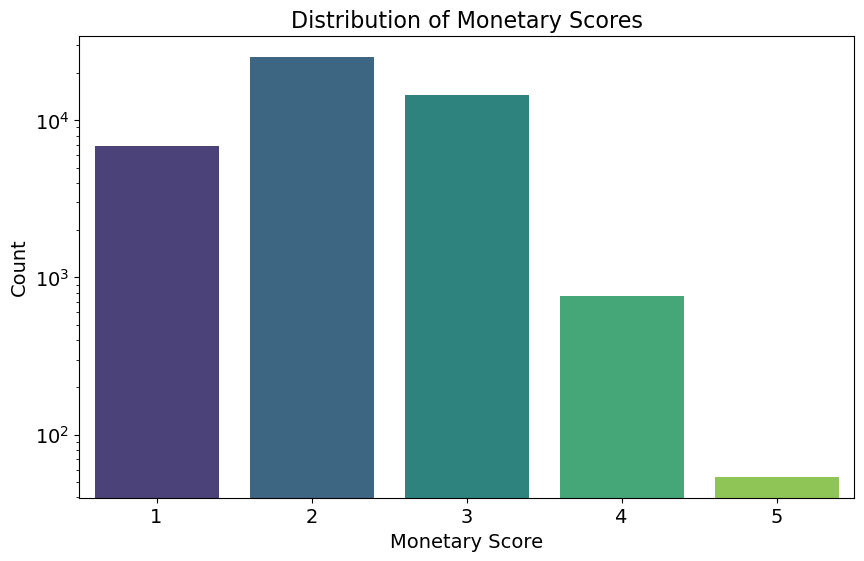

In [183]:
# distribution by monetary score
plt.figure(figsize=(10, 6))
sns.countplot(x='Monetary Score', data=active_customers_rfm, palette='viridis')
plt.title('Distribution of Monetary Scores')
plt.xlabel('Monetary Score')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\1769270700.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Monetary Score', y='Monetary Value', data=active_customers_rfm, estimator=sum, ci=None, palette='viridis')


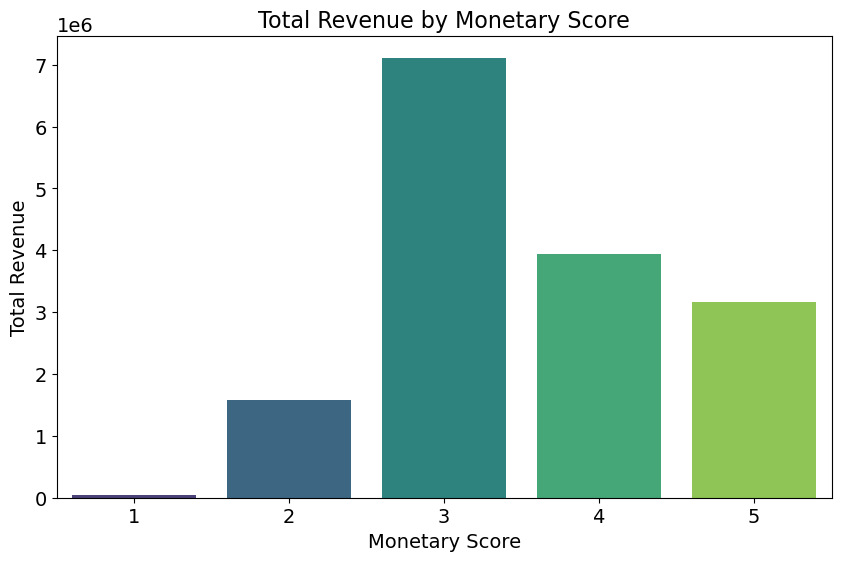

In [185]:
# total revenue by monetary score
plt.figure(figsize=(10, 6))
sns.barplot(x='Monetary Score', y='Monetary Value', data=active_customers_rfm, estimator=sum, ci=None, palette='viridis')
plt.title('Total Revenue by Monetary Score')
plt.xlabel('Monetary Score')
plt.ylabel('Total Revenue')
plt.show()

## RFM Analysis Finalization

Calculating the RF Groups and Monetary Scores allows us to group customers as different marketing strategy targets.

1. Expendable Customers
2. Occasional to Frequent
3. Frequents At risk
4. Potentials to invest on
5. Extremely Worthy to retain
6. VIP to consider sepecial services

In [193]:
# Define the new labels based on monetary score
def final_label(row):
    monetary_score_label = {
        1: "Expendable Customers",
        2: "Potential Growth Customers",
        3: "Regular Valued Customers",
        4: "High Priority Customers",
        5: "VIP Customers"
    }
    return f"{row['Customer_Label']} - {monetary_score_label[row['Monetary Score']]}"

# Apply the new labels to the dataframe
active_customers_rfm['Final_Label'] = active_customers_rfm.apply(final_label, axis=1)

C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_8872\2824042668.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_customers_rfm['Final_Label'] = active_customers_rfm.apply(final_label, axis=1)


In [200]:
active_customers_rfm

,customer_id,Recency,Frequency,Monetary Value,Anomaly,R_Score,F_Score,Customer_Label,Monetary Score,Monetary Value Log,Final_Label
0,23,70,8,483.51,0,4,4,Frequent At-Risk,3,6.183138,Frequent At-Risk - Regular Valued Customers
2,32,29,3,58.85,0,2,2,Potential Occasional,2,4.091841,Potential Occasional - Potential Growth Customers
3,48,1,20,1053.62,0,1,4,Frequent Active Customers,3,6.960936,Frequent Active Customers - Regular Valued Cus...
4,50,71,2,28.75,0,4,2,Burnt Potential,2,3.392829,Burnt Potential - Potential Growth Customers
6,76,54,2,14.60,0,3,2,Burnt Potential,2,2.747271,Burnt Potential - Potential Growth Customers
...,...,...,...,...,...,...,...,...,...,...,...
104129,934484,1,1,39.10,0,1,1,One-Timers,2,3.691376,One-Timers - Potential Growth Customers
104130,934581,1,1,33.60,0,1,1,One-Timers,2,3.543854,One-Timers - Potential Growth Customers
104131,934620,1,1,21.98,0,1,1,One-Timers,2,3.134624,One-Timers - Potential Growth Customers
104132,934660,1,1,1.90,0,1,1,One-Timers,1,1.064711,One-Timers - Expendable Customers


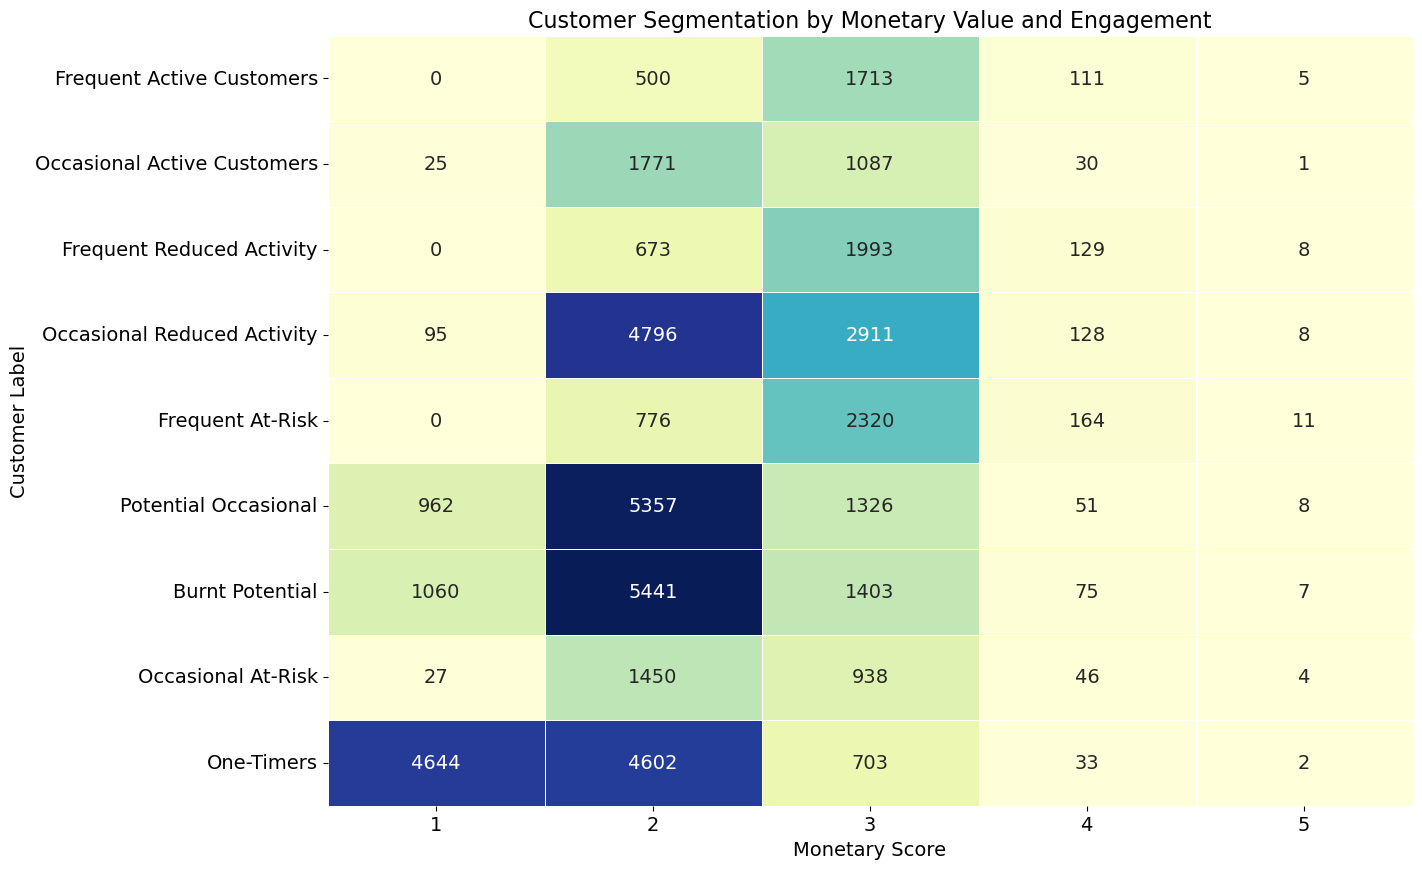

In [201]:
# Define the importance order based on interpretation
importance_order = [
    "Frequent Active Customers", # Most important
    "Occasional Active Customers",
    "Frequent Reduced Activity",
    "Occasional Reduced Activity",
    "Frequent At-Risk",
    "Potential Occasional",
    "Burnt Potential",
    "Occasional At-Risk",
    "One-Timers", # Least important
]

# Define the categories for both axes
monetary_labels = [1, 2, 3, 4, 5]

# Create a pivot table from the customer data
pivot_table = pd.pivot_table(
    active_customers_rfm, 
    values='customer_id', 
    index='Customer_Label', 
    columns='Monetary Score', 
    aggfunc='count',
    fill_value=0
)

# Reorder the pivot table based on the importance order
pivot_table = pivot_table.reindex(index=importance_order, columns=monetary_labels, fill_value=0)

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", cbar=False, linewidths=.5)

# Adjust the labels and title
plt.title('Customer Segmentation by Monetary Value and Engagement')
plt.xlabel('Monetary Score')
plt.ylabel('Customer Label')

# Show the plot
plt.show()

# Final RFM Grouping

After Assigning RFM values to active users, Inactive users will be concatenated. 

**Important Note** : Inactive users with extremely high monetary value will be assigned the "Inactive High Monetary" to be set aside as special customers that are supposedly churned but also may be Seasonal customers.

In [204]:
# in rfm table, in a RFM LAbel column, label the customers with values at active_customers_rfm['Final_Label'] and for customers inactive label 'inactive' for anomolies label' Anomaly'
rfm_table['RFM Label'] = rfm_table['customer_id'].map(active_customers_rfm.set_index('customer_id')['Final_Label']).fillna('Inactive')
rfm_table['RFM Label'] = rfm_table['RFM Label'].mask(rfm_table['Anomaly'] == 1, 'Anomaly')

rfm_table['RFM Label'].value_counts()


RFM Label
Inactive                                                    56662
Burnt Potential - Potential Growth Customers                 5441
Potential Occasional - Potential Growth Customers            5357
Occasional Reduced Activity - Potential Growth Customers     4796
One-Timers - Expendable Customers                            4644
One-Timers - Potential Growth Customers                      4602
Occasional Reduced Activity - Regular Valued Customers       2911
Frequent At-Risk - Regular Valued Customers                  2320
Frequent Reduced Activity - Regular Valued Customers         1993
Occasional Active Customers - Potential Growth Customers     1771
Frequent Active Customers - Regular Valued Customers         1713
Occasional At-Risk - Potential Growth Customers              1450
Burnt Potential - Regular Valued Customers                   1403
Potential Occasional - Regular Valued Customers              1326
Occasional Active Customers - Regular Valued Customers       1087


# Visualization

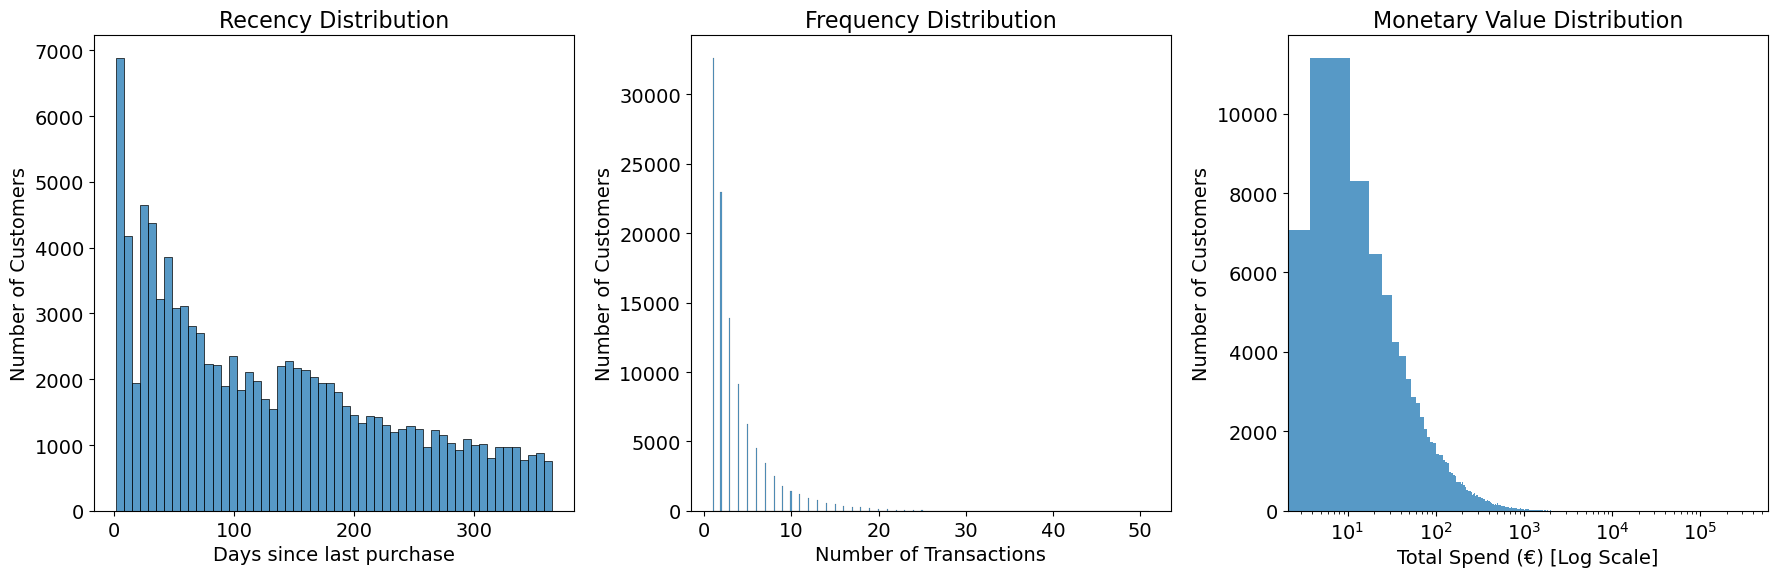

In [168]:
plt.figure(figsize=(18, 6))

# Histogram for Recency
plt.subplot(1, 3, 1)
sns.histplot(rfm_table['Recency'], kde=False)
plt.title('Recency Distribution')
plt.xlabel('Days since last purchase')
plt.ylabel('Number of Customers')

# Histogram for Frequency
plt.subplot(1, 3, 2)
sns.histplot(rfm_table['Frequency'], kde=False)
plt.title('Frequency Distribution')
plt.xlabel('Number of Transactions')
plt.ylabel('Number of Customers')

# Histogram for Monetary Value with Log Scale
plt.subplot(1, 3, 3)
sns.histplot(rfm_table['Monetary Value'], kde=False)
plt.xscale('log')
plt.title('Monetary Value Distribution')
plt.xlabel('Total Spend (€) [Log Scale]')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()


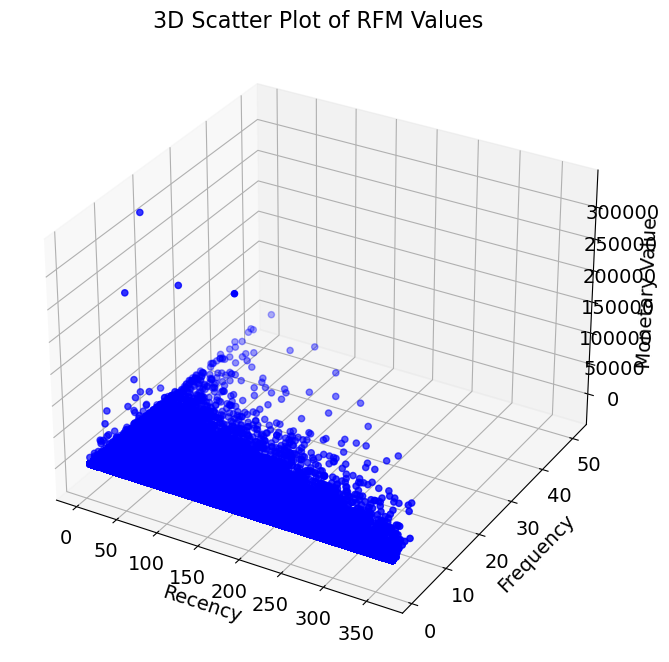

In [169]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm_table['Recency']
y = rfm_table['Frequency']
z = rfm_table['Monetary Value']

ax.scatter(x, y, z, c='blue', marker='o')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
ax.set_title('3D Scatter Plot of RFM Values')

plt.show()


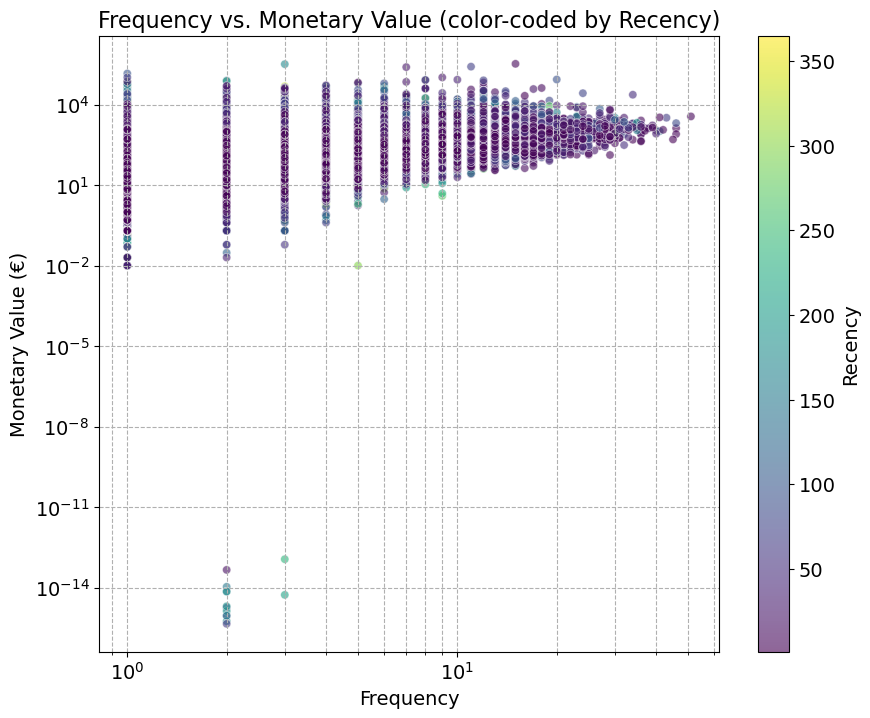

In [170]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    rfm_table['Frequency'],
    rfm_table['Monetary Value'],
    c=rfm_table['Recency'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

plt.colorbar(scatter, label='Recency')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Monetary Value (€)')
plt.title('Frequency vs. Monetary Value (color-coded by Recency)')
plt.grid(True, which="both", ls="--")

plt.show()


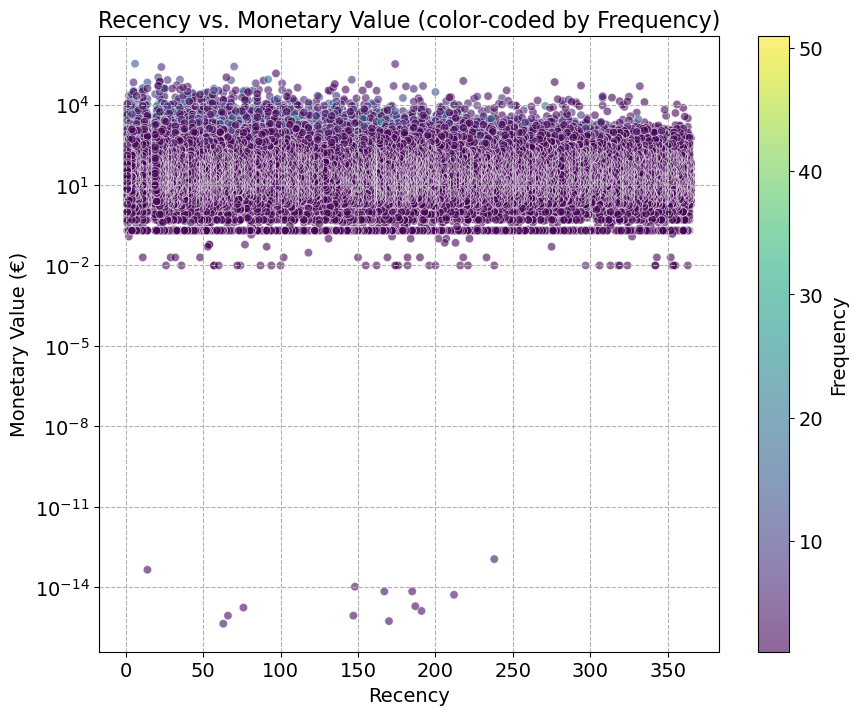

In [171]:
plt.figure(figsize=(10, 8))

scatter = plt.scatter(
    rfm_table['Recency'],
    rfm_table['Monetary Value'],
    c=rfm_table['Frequency'],
    cmap='viridis',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)

plt.colorbar(scatter, label='Frequency')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Recency')
plt.ylabel('Monetary Value (€)')
plt.title('Recency vs. Monetary Value (color-coded by Frequency)')
plt.grid(True, which="both", ls="--")

plt.show()


In [172]:
rfm_table[rfm_table['Monetary Value'] <= 0]

,customer_id,Recency,Frequency,Monetary Value,Active,Anomaly
100,807,247,2,0.0,0,0
457,3139,223,2,0.0,0,0
999,6841,223,2,0.0,0,0
1024,7101,303,2,0.0,0,0
1027,7116,153,2,0.0,0,0
...,...,...,...,...,...,...
102670,895527,4,2,0.0,1,0
102921,899198,11,2,0.0,1,0
103071,901316,25,2,0.0,1,0
103248,904351,7,2,0.0,1,0


In [173]:
customer_data[customer_data['customer_id'] == 904030]

,customer_id,address_id,birthdate,gender,job_type,email_provider,flag_phone_provided,flag_privacy
18781,904030,876902,1975-12-08,M,NaN,gmail.com,1.0,True


In [174]:
customer_accounts_data[customer_accounts_data['customer_id'] == 904030]

,customer_id,account_id,favorite_store,loyalty_type,loyatlty_status,activation_date
138949,904030,892682,6,business premium,1,2023-04-07


In [175]:
orders_data[orders_data['customer_id'] == 904030]

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
1035903,95fe6ea23fb93581fd54e718a9fb6380,904030,6,36323616,1,15.49,0.0,2023-04-08 11:42:06


In [176]:
negative_price_items = orders_data[(orders_data['gross_price'] < 0) & (orders_data['direction'] == 1)]
negative_price_items

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime


In [177]:
negative_price_items['product_id'].unique()

array([], dtype=int64)

In [178]:
orders_data[orders_data['product_id'] == 35619745]

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
14191,4681bff21a97bd09c0bd6735093df72b,8624,33,35619745,1,79.0,0.0,2023-01-29 09:22:14
19225,4d265ba4f226971125bdb63336551323,11672,33,35619745,1,79.0,0.0,2022-08-06 12:38:16
20161,bfeb85c724a470ff79ca466f70a5e250,12516,41,35619745,1,79.0,0.0,2022-07-04 19:57:49
23350,9ee1c5dc123f2a9f82d36a5dc0ba7a51,14956,11,35619745,1,79.0,0.0,2022-05-09 18:17:18
30360,0ae265fed8b842bc421ea8b5d83f3fcc,19204,10,35619745,1,79.0,0.0,2023-04-06 18:18:14
...,...,...,...,...,...,...,...,...
1034191,e87a0443f5ae1f0f1072141de2ce5bd6,899036,3,35619745,1,79.0,0.0,2023-04-05 13:15:22
1035398,db4a4484336e9384e1375420adc4ce8c,902489,45,35619745,1,79.0,0.0,2023-04-12 17:31:46
1037676,1673532f2e185a094bfe366be46cd29a,914213,17,35619745,1,79.0,0.0,2023-04-24 11:29:34
1037886,452c518535e04f44456a475345523738,916124,5,35619745,1,79.0,0.0,2023-04-25 18:03:00


In [179]:
negative_price_items[negative_price_items['product_id'] == 35619745]

,order_id,customer_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime
